In [260]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

In [261]:
def load_power_data(start_date, end_date):
   """
   Fetch and process Danish energy data from Energinet API.
   
   Parameters:
   -----------
   start_date : str
       Start date in format 'YYYY-MM-DD'
   end_date : str
       End date in format 'YYYY-MM-DD'
   
   Returns:
   --------
   pandas.DataFrame
       Processed DataFrame with hourly energy data, indexed by datetime
   """

   # Construct API URL
   url = f'https://api.energidataservice.dk/dataset/ElectricityBalanceNonv?start={start_date}&end={end_date}&sort=HourUTC'
   
   try:
       # Fetch data from API
       response = requests.get(url)
       response.raise_for_status()  # Raise exception for bad status codes
       
       # Process the JSON response
       data = response.json()
       df = pd.json_normalize(data['records'])
       
       # Clean and process the data
       df.fillna(0, inplace=True)
       
       # Sum values for each hour (combine price areas) and drop unnecessary columns. Data is then in Danish timezone.
       summed_df = df.drop(['HourUTC', 'PriceArea'], axis=1).groupby('HourDK').sum()
       
       # Convert index to datetime
       summed_df.index = pd.to_datetime(summed_df.index)
       
       return summed_df
       
   # Raise exceptions if data not fetched    
   except requests.exceptions.RequestException as e:
       raise Exception(f"Error fetching data from API: {str(e)}")
   except Exception as e:
       raise Exception(f"Error processing data: {str(e)}")

In [262]:
# start and end of loaded data
start_data = '2024-01-01'
end_data = '2025-01-01'

dataframe = load_power_data(start_data, end_data)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TotalLoad                8783 non-null   float64
 1   Biomass                  8783 non-null   float64
 2   FossilGas                8783 non-null   float64
 3   FossilHardCoal           8783 non-null   float64
 4   FossilOil                8783 non-null   float64
 5   HydroPower               8783 non-null   float64
 6   OtherRenewable           8783 non-null   float64
 7   SolarPower               8783 non-null   float64
 8   Waste                    8783 non-null   float64
 9   OnshoreWindPower         8783 non-null   float64
 10  OffshoreWindPower        8783 non-null   float64
 11  ExchangeContinent        8783 non-null   float64
 12  ExchangeGreatBelt        8783 non-null   float64
 13  ExchangeNordicCountries  8783 non-null   f

In [269]:
def plot_power_generation(df, columns_to_plot, scale_factors=None, start=None, end=None, 
                        title="Danmarks elsystem", plot_load=True):
    """
    Create a stacked area plot with black edges for power generation data.
    
    Parameters:
    -----------
    plot_df : DataFrame
        DataFrame with datetime index and selected technologies to plot
    scale_factors : dict, optional
        Dictionary with technology names as keys and scale factors as values
        e.g., {'SolarPower': 0.5, 'OnshoreWindPower': 1.2}
    start : str, optional
        Start date in format 'YYYY-MM-DD'
    end : str, optional
        End date in format 'YYYY-MM-DD'
    title : str, optional
        Plot title
    """
    
    from datetime import timedelta
    import matplotlib.dates as mdates
    import matplotlib.ticker as ticker

    # Font for plots (try others if wanted)
    plt.rc("font", family=["Helvetica Neue"])

    
    # Fixed colors for technologies
    colors = {
        'SolarPower': '#FDB813',          # Yellow/Gold
        'OnshoreWindPower': '#00A0DC',    # Light Blue
        'OffshoreWindPower': '#2E8B57',   # Sea Green
        'FossilGas': '#FF7F50',           # Coral
        'FossilHardCoal': '#808080',      # Gray
        'Biomass': '#90EE90',             # Light Green
        'FossilOil': '#8B4513'            # Brown
    }

    # Danish name mapping
    danish_names = {
        'OnshoreWindPower': 'Landvind',
        'OffshoreWindPower': 'Havvind',
        'SolarPower': 'Sol',
        'Biomass': 'Biomasse',
        'FossilHardCoal' : 'Kul',
        'FossilGas' : 'Gas',
        'FossilOil' : 'Olie'
    }
    
    # Create a copy and apply scaling if provided
    df = df.copy()
    if scale_factors:
        for tech, factor in scale_factors.items():
            if tech in df.columns:
                df[tech] = df[tech] * factor
    
    # Filter date range if provided
    if start:
        df = df[start:]
    if end:
        df = df[:end]
    
    plt.figure(figsize=(12, 6))
    
    # Create stacked area plot
    y_stack = np.zeros(len(df))
    
    # Plot each technology. Create labels with danish name and add scale factor
    for column in df[columns_to_plot].columns:
        base_label = danish_names.get(column, column)
        # Add scale factor to legend if it exists
        if scale_factors and column in scale_factors:
            label = f"{base_label} (×{scale_factors[column]})"
        else:
            label = base_label
        color = colors.get(column, '#CCCCCC')  # Default to gray if column not in colors dict
        plt.fill_between(df.index, y_stack, y_stack + df[column], 
                        alpha=0.6, color=color, label=label)
        plt.plot(df.index, y_stack + df[column], color='black', linewidth=0.75)
        y_stack += df[column]


    # For plotting load. If load is not scaled, simply plot it. If load is scaled, create label with scale value    
    if plot_load and 'TotalLoad' not in scale_factors:
        plt.plot(df.index, df['TotalLoad'], color='black',alpha=1, linestyle='--', linewidth=2,label='Forbrug',zorder=10)
    if plot_load and 'TotalLoad' in scale_factors:
        load_label = f"Forbrug (×{scale_factors['TotalLoad']})"
        plt.plot(df.index, df['TotalLoad'], color='black',alpha=1, linestyle='--', linewidth=2,label=load_label,zorder=10)
        
    
    # Customize the plot
    plt.title(title, fontsize=20, pad=10)
    plt.xlabel('Dato', fontsize=12)
    plt.ylabel('Effekt (MW)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left',fontsize=12,framealpha=1)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize=11.5)

    # set x limits
    plt.xlim(pd.to_datetime(start), pd.to_datetime(end))

    # set dynamic y-limit
    y_max = df[columns_to_plot].sum(axis=1).max()
    plt.ylim(0, y_max*1.05)


    # set dynamic x ticks
    ax = plt.gca()
    time_span = df.index.max() - df.index.min()

    # Create auto date locator with better interval choices
    locator = mdates.AutoDateLocator(minticks=7, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)

    # Override the formatter's formats based on our time span
    if time_span <= timedelta(days=1):
        date_format = '%H:%M'  # Just hours and minutes for single day
    elif time_span <= timedelta(days=14):
        date_format = '%d-%m %H:%M'
    elif time_span <= timedelta(days=365):
        date_format = '%d-%m-%Y'
    else:
        date_format = '%Y-%m'

    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    plt.gcf().autofmt_xdate()

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

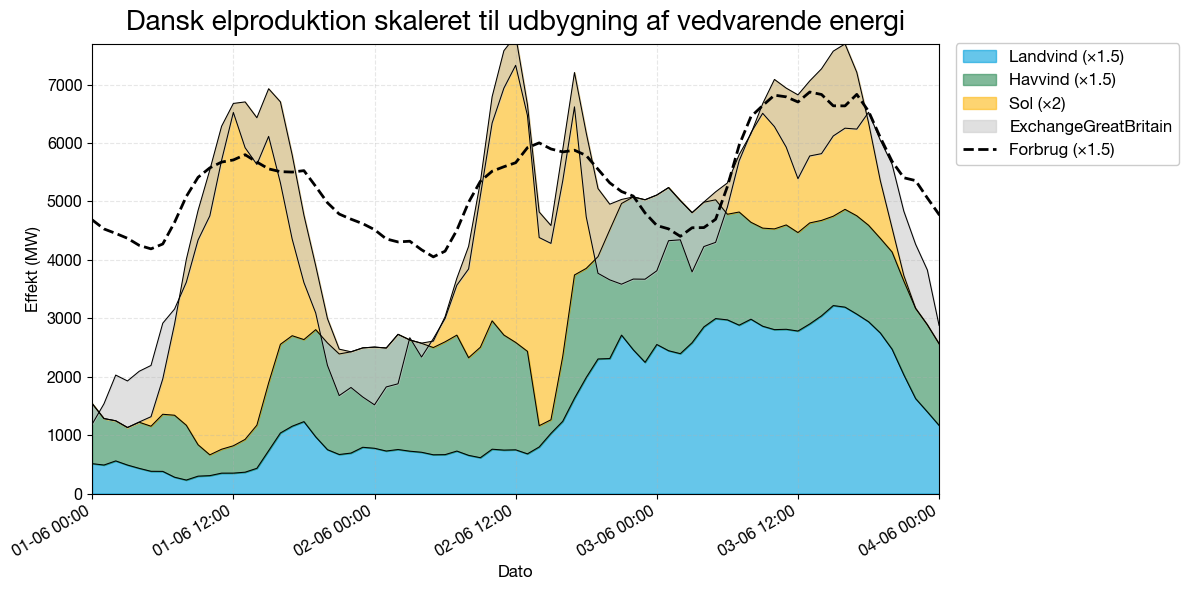

In [271]:
data_to_plot = ['OnshoreWindPower', 'OffshoreWindPower', 'SolarPower'] # Add the other technologies from the dataframe if wanted

# Dictionary with scaling factors
scale_factors = {
    'OnshoreWindPower':1.5,
    'OffshoreWindPower':1.5, 
    'SolarPower':2,
    'TotalLoad':1.5
}

# Start and end of the plot
start_plot = '2024-06-01'
end_plot = '2024-06-04'

# Title of the plot
titel = 'Dansk elproduktion skaleret til udbygning af vedvarende energi'

# Call the plotting function
plot_power_generation(dataframe, data_to_plot, scale_factors=scale_factors, start=start_plot,end=end_plot, title=titel, plot_load=True)

# Save the figure in high resolution
plt.savefig('Elsystem.jpg', dpi=800, bbox_inches='tight')